<a href="https://colab.research.google.com/github/snaily16/GAN-Implementations-Pytorch/blob/master/CGAN/ConditionalDCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Conditional DCGAN

In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-e87d63e0-be79-cf3a-e6b7-aeb16c94e815)


In [ ]:
#!git clone https://github.com/TeeyoHuang/conditional-GAN/
!python conditional-GAN/conditional_DCGAN.py

In [23]:
%matplotlib inline

import time, os
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import itertools, pickle, imageio
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader
from torch.autograd import Variable
from torchsummary import summary

Set Hyperparameters

In [3]:
# Hyperparameters
batch_size=128
num_epochs=50
image_size=32
stats = (0.5), (0.5)
latent_size=100
n_classes=10
lr = 0.0002
b1 = 0.5
b2=0.999
channels=1
img_shape = (channels, image_size, image_size)

In [4]:
# Device configuration
cuda = True if torch.cuda.is_available() else False
device = torch.device('cuda' if cuda else 'cpu')

## Load Dataset

In [18]:
transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(*stats)
])

mnist_data = datasets.MNIST('data', train=True, download=True, transform=transform)
train_loader = DataLoader(mnist_data, batch_size=batch_size ,shuffle=True, drop_last=True)

In [6]:
# results save folder
if not os.path.isdir('MNIST_cDCGAN_results'):
    os.mkdir('MNIST_cDCGAN_results')

In [7]:
def normal_init(m, mean, std):
  if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
    m.weight.data.normal_(mean, std)
    m.bias.data.zero_()

## Generator Network

In [8]:
class Generator(nn.Module):
  def __init__(self, d=128):
    super(Generator, self).__init__()
    
    self.deconv1_1 = nn.ConvTranspose2d(latent_size, d*2, 4, 1, 0)
    self.bn1_1 = nn.BatchNorm2d(d*2)
    self.deconv1_2 = nn.ConvTranspose2d(n_classes, d*2, 4, 1, 0)
    self.bn1_2 = nn.BatchNorm2d(d*2)
    self.deconv2 = nn.ConvTranspose2d(d*4, d*2, 4, 2, 1)
    self.bn2 = nn.BatchNorm2d(d*2)
    self.deconv3 = nn.ConvTranspose2d(d*2, d, 4, 2, 1)
    self.bn3 = nn.BatchNorm2d(d)
    self.deconv4 = nn.ConvTranspose2d(d, channels, 4, 2, 1)

  # weight_init
  def weight_init(self, mean, std):
    for m in self._modules:
      normal_init(self._modules[m], mean, std)

  # forward method
  def forward(self, input, label):
    x = F.relu(self.bn1_1(self.deconv1_1(input)))
    y = F.relu(self.bn1_2(self.deconv1_2(label)))
    x = torch.cat([x, y], 1)
    x = F.relu(self.bn2(self.deconv2(x)))
    x = F.relu(self.bn3(self.deconv3(x)))
    x = F.tanh(self.deconv4(x))
    return x

In [9]:
G = Generator(128)
G.weight_init(mean=0, std=0.02)
G.to(device)
print(G)
#summary(G,[(1,28,28),(1,10,10)])

Generator(
  (deconv1_1): ConvTranspose2d(100, 256, kernel_size=(4, 4), stride=(1, 1))
  (bn1_1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv1_2): ConvTranspose2d(10, 256, kernel_size=(4, 4), stride=(1, 1))
  (bn1_2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv2): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv4): ConvTranspose2d(128, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
)


## Discriminator Network

In [10]:
class Discriminator(nn.Module):
  def __init__(self, d=128):
    super(Discriminator, self).__init__()

    self.conv1_1 = nn.Conv2d(channels, d//2, 4, 2, 1)
    self.conv1_2 = nn.Conv2d(n_classes, d//2, 4, 2, 1)
    self.conv2 = nn.Conv2d(d, d*2, 4, 2, 1)
    self.bn2 = nn.BatchNorm2d(d*2)
    self.conv3 = nn.Conv2d(d*2, d*4, 4, 2, 1)
    self.bn3 = nn.BatchNorm2d(d*4)
    self.conv4 = nn.Conv2d(d * 4, 1, 4, 1, 0)

  # weight_init
  def weight_init(self, mean, std):
    for m in self._modules:
      normal_init(self._modules[m], mean, std)

  # forward method
  def forward(self, input, label):
    x = F.leaky_relu(self.conv1_1(input), 0.2)
    y = F.leaky_relu(self.conv1_2(label), 0.2)
    x = torch.cat([x, y], 1)
    x = F.leaky_relu(self.bn2(self.conv2(x)), 0.2)
    x = F.leaky_relu(self.bn3(self.conv3(x)), 0.2)
    x = F.sigmoid(self.conv4(x))

    return x

In [11]:
D = Discriminator(128)
D.weight_init(mean=0, std=0.02)
D.to(device)
print(D)

Discriminator(
  (conv1_1): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv1_2): Conv2d(10, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1))
)


## Loss function and Optimizers

In [12]:
criterion = nn.BCELoss()
d_optimizer = optim.Adam(D.parameters(), lr=lr, betas=(b1, b2))
g_optimizer = optim.Adam(G.parameters(), lr=lr, betas=(b1, b2))

### Helper functions

In [13]:
def generate_random_latent():
  return Variable(torch.rand(batch_size,latent_size,1,1).to(device))

def generate_random_labels():
  y = (torch.rand(batch_size, 1)*n_classes).type(torch.LongTensor)
  gen_y = torch.zeros(batch_size, n_classes)
  gen_y = Variable(gen_y.scatter_(1,y.view(batch_size,1),1).view(batch_size,n_classes,1,1).to(device))
  gen_y_for_D = gen_y.view(batch_size, n_classes, 1, 1).contiguous().expand(-1, -1, image_size, image_size)
  return gen_y, gen_y_for_D

In [21]:
## To random latents noise and 1-10 embeddings to save sample generated images

noise = Variable(torch.FloatTensor(np.random.normal(0, 1, (n_classes**2, latent_size,1,1))).to(device))
#fixed labels
y_ = torch.LongTensor(np.array([num for num in range(n_classes)])).view(n_classes,1).expand(-1,n_classes).contiguous()  # num_classes x num_classes
y_fixed = torch.zeros(n_classes**2, n_classes)
y_fixed = Variable(y_fixed.scatter_(1,y_.view(n_classes**2,1),1).view(n_classes**2, n_classes,1,1).to(device))

print(noise.shape, y_fixed.shape)

torch.Size([100, 100, 1, 1]) torch.Size([100, 10, 1, 1])


Training functions

In [15]:
def train_discriminator(images, labels):
  # create labels
  mini_batch = images.shape[0]
  real_labels = Variable(torch.ones(mini_batch).to(device))
  fake_labels = Variable(torch.zeros(batch_size).to(device))
    
  # ============================
  #   Train the discriminator
  # ============================

  # Compute BCELoss using real images
  # where BCE_Loss(x, y): - y * log(D(x,y)) - (1-y) * log(1 - D(x,y))
  # Second term of the loss is always zero since real_labels == 1
  
  x = Variable(images.to(device))
  #y = Variable(fill[labels].to(device))
  
  outputs = D(x, labels).squeeze()
  d_real_loss = criterion(outputs, real_labels)
  real_score = outputs

  # compute BCELoss using fake images
  # First term of the loss is always zero since fake_labels == 0
  z = generate_random_latent()
  gen_y, gen_y_D = generate_random_labels()
  
  gen_images = G(z, gen_y)
  outputs = D(gen_images, gen_y_D).squeeze()
  d_fake_loss = criterion(outputs, fake_labels)
  fake_score = outputs

  # Backprop and optimize
  d_loss = d_real_loss + d_fake_loss
  d_optimizer.zero_grad()
  d_loss.backward()
  d_optimizer.step()

  return d_loss, real_score, fake_score

In [16]:
def train_generator():
  real_labels = Variable(torch.ones(batch_size).to(device))
  
  # ============================
  #    Train the Generator
  # ============================
    
  # compute loss with fake image
  z = generate_random_latent()
  gen_y, gen_y_D = generate_random_labels()
  gen_images = G(z, gen_y)
  outputs = D(gen_images, gen_y_D)

  # train G to maximize log(D(G(z)))
  g_loss = criterion(outputs, real_labels)

  # Backprop and optimize
  g_optimizer.zero_grad()
  g_loss.backward()
  g_optimizer.step()
  
  return g_loss, gen_images

In [24]:
# Start Training
batches_done =0
d_losses, g_losses, real_scores, fake_scores =[],[],[],[]
path = 'MNIST_cDCGAN_results'
total_batches = len(train_loader)-1

for epoch in range(num_epochs):
  D_loss, G_loss = [], []
  for images,labels in tqdm(train_loader):
    
    real_imgs = Variable(images.type(torch.FloatTensor).to(device))
    onehotVec = torch.zeros(batch_size, n_classes)
    onehotVec = onehotVec.scatter_(1,labels.view(batch_size,1),1).view(batch_size, n_classes, 1, 1).contiguous()
    onehotVec = Variable(onehotVec.expand(-1,-1,image_size,image_size).to(device))

    d_loss, real_score, fake_score = train_discriminator(real_imgs,onehotVec)
    g_loss, fake_images = train_generator()

    if batches_done%(total_batches//2)==0:
      d_losses.append(d_loss.item())
      g_losses.append(g_loss.item())
      real_scores.append(real_score.mean().item())
      fake_scores.append(fake_score.mean().item())

      gen_imgs = G(noise, y_fixed).view(-1,channels,image_size,image_size)
      save_image(gen_imgs.data, path+ '/%d%d.png' % (epoch,batches_done), nrow=n_classes, normalize=True)
      print("Epochs: [%d/%d], Steps: [%d/%d], d_loss: %.3f, g_loss: %.3f" % 
            (epoch+1, num_epochs, batches_done+1, total_batches, d_loss.item(), g_loss.item()))
    batches_done=((batches_done)%total_batches+1)%total_batches
  

torch.save(G.state_dict(), 'G.ckpt')
torch.save(D.state_dict(), 'D.ckpt')

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1614: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1, 1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Epochs: [1/50], Steps: [1/467], d_loss: 1.665, g_loss: 3.826
Epochs: [1/50], Steps: [234/467], d_loss: 0.907, g_loss: 2.720
Epochs: [1/50], Steps: [467/467], d_loss: 0.430, g_loss: 3.470
Epochs: [1/50], Steps: [1/467], d_loss: 0.559, g_loss: 3.283



Epochs: [2/50], Steps: [234/467], d_loss: 0.469, g_loss: 3.132
Epochs: [2/50], Steps: [467/467], d_loss: 0.551, g_loss: 2.850
Epochs: [2/50], Steps: [1/467], d_loss: 0.855, g_loss: 4.367



Epochs: [3/50], Steps: [234/467], d_loss: 0.496, g_loss: 2.988
Epochs: [3/50], Steps: [467/467], d_loss: 0.848, g_loss: 2.753
Epochs: [3/50], Steps: [1/467], d_loss: 0.490, g_loss: 3.818



Epochs: [4/50], Steps: [234/467], d_loss: 0.971, g_loss: 2.888
Epochs: [4/50], Steps: [467/467], d_loss: 0.510, g_loss: 3.772
Epochs: [4/50], Steps: [1/467], d_loss: 0.363, g_loss: 3.369



Epochs: [5/50], Steps: [234/467], d_loss: 0.880, g_loss: 5.032
Epochs: [5/50], Steps: [467/467], d_loss: 0.450, g_loss: 2.419
Epochs: [5/50], Steps: [1/467], d_loss: 1.024, g_loss: 9.394



Epochs: [6/50], Steps: [234/467], d_loss: 0.553, g_loss: 6.795
Epochs: [6/50], Steps: [467/467], d_loss: 0.179, g_loss: 4.021
Epochs: [6/50], Steps: [1/467], d_loss: 0.233, g_loss: 5.025



Epochs: [7/50], Steps: [234/467], d_loss: 0.255, g_loss: 6.383
Epochs: [7/50], Steps: [467/467], d_loss: 0.281, g_loss: 3.323
Epochs: [7/50], Steps: [1/467], d_loss: 0.281, g_loss: 4.323



Epochs: [8/50], Steps: [234/467], d_loss: 0.483, g_loss: 5.367
Epochs: [8/50], Steps: [467/467], d_loss: 0.483, g_loss: 3.643
Epochs: [8/50], Steps: [1/467], d_loss: 0.260, g_loss: 2.865



Epochs: [9/50], Steps: [234/467], d_loss: 0.262, g_loss: 2.309
Epochs: [9/50], Steps: [467/467], d_loss: 0.164, g_loss: 3.616
Epochs: [9/50], Steps: [1/467], d_loss: 0.227, g_loss: 5.325



Epochs: [10/50], Steps: [234/467], d_loss: 0.988, g_loss: 8.897
Epochs: [10/50], Steps: [467/467], d_loss: 0.211, g_loss: 4.191
Epochs: [10/50], Steps: [1/467], d_loss: 0.214, g_loss: 3.930



Epochs: [11/50], Steps: [234/467], d_loss: 0.359, g_loss: 2.223
Epochs: [11/50], Steps: [467/467], d_loss: 0.183, g_loss: 3.871
Epochs: [11/50], Steps: [1/467], d_loss: 0.246, g_loss: 5.402



Epochs: [12/50], Steps: [234/467], d_loss: 0.229, g_loss: 4.673
Epochs: [12/50], Steps: [467/467], d_loss: 0.336, g_loss: 3.078
Epochs: [12/50], Steps: [1/467], d_loss: 0.394, g_loss: 6.267



Epochs: [13/50], Steps: [234/467], d_loss: 0.110, g_loss: 5.019
Epochs: [13/50], Steps: [467/467], d_loss: 0.234, g_loss: 3.461
Epochs: [13/50], Steps: [1/467], d_loss: 0.371, g_loss: 6.080



Epochs: [14/50], Steps: [234/467], d_loss: 0.045, g_loss: 4.224
Epochs: [14/50], Steps: [467/467], d_loss: 0.319, g_loss: 6.031
Epochs: [14/50], Steps: [1/467], d_loss: 0.318, g_loss: 6.546



Epochs: [15/50], Steps: [234/467], d_loss: 0.374, g_loss: 4.490
Epochs: [15/50], Steps: [467/467], d_loss: 0.069, g_loss: 5.032
Epochs: [15/50], Steps: [1/467], d_loss: 0.101, g_loss: 4.341



Epochs: [16/50], Steps: [234/467], d_loss: 0.035, g_loss: 4.606
Epochs: [16/50], Steps: [467/467], d_loss: 0.049, g_loss: 5.196
Epochs: [16/50], Steps: [1/467], d_loss: 0.062, g_loss: 4.420



Epochs: [17/50], Steps: [234/467], d_loss: 0.306, g_loss: 4.459
Epochs: [17/50], Steps: [467/467], d_loss: 0.109, g_loss: 3.936
Epochs: [17/50], Steps: [1/467], d_loss: 0.137, g_loss: 5.447



Epochs: [18/50], Steps: [234/467], d_loss: 0.103, g_loss: 4.392
Epochs: [18/50], Steps: [467/467], d_loss: 0.169, g_loss: 4.998
Epochs: [18/50], Steps: [1/467], d_loss: 0.117, g_loss: 5.171



Epochs: [19/50], Steps: [234/467], d_loss: 0.100, g_loss: 5.442
Epochs: [19/50], Steps: [467/467], d_loss: 0.041, g_loss: 6.468
Epochs: [19/50], Steps: [1/467], d_loss: 0.142, g_loss: 4.452



Epochs: [20/50], Steps: [234/467], d_loss: 0.156, g_loss: 3.866
Epochs: [20/50], Steps: [467/467], d_loss: 0.053, g_loss: 5.353
Epochs: [20/50], Steps: [1/467], d_loss: 0.115, g_loss: 5.924



Epochs: [21/50], Steps: [234/467], d_loss: 0.145, g_loss: 4.805
Epochs: [21/50], Steps: [467/467], d_loss: 0.097, g_loss: 5.311
Epochs: [21/50], Steps: [1/467], d_loss: 0.063, g_loss: 4.772



Epochs: [22/50], Steps: [234/467], d_loss: 0.091, g_loss: 5.300
Epochs: [22/50], Steps: [467/467], d_loss: 0.205, g_loss: 4.226
Epochs: [22/50], Steps: [1/467], d_loss: 0.054, g_loss: 4.011



Epochs: [23/50], Steps: [234/467], d_loss: 0.200, g_loss: 5.080
Epochs: [23/50], Steps: [467/467], d_loss: 0.051, g_loss: 5.686
Epochs: [23/50], Steps: [1/467], d_loss: 0.163, g_loss: 4.991



Epochs: [24/50], Steps: [234/467], d_loss: 2.147, g_loss: 19.366
Epochs: [24/50], Steps: [467/467], d_loss: 0.104, g_loss: 3.839
Epochs: [24/50], Steps: [1/467], d_loss: 0.057, g_loss: 4.644



Epochs: [25/50], Steps: [234/467], d_loss: 0.092, g_loss: 2.705
Epochs: [25/50], Steps: [467/467], d_loss: 0.046, g_loss: 6.681
Epochs: [25/50], Steps: [1/467], d_loss: 0.155, g_loss: 3.936



Epochs: [26/50], Steps: [234/467], d_loss: 0.280, g_loss: 8.955
Epochs: [26/50], Steps: [467/467], d_loss: 0.056, g_loss: 5.332
Epochs: [26/50], Steps: [1/467], d_loss: 0.149, g_loss: 4.657



Epochs: [27/50], Steps: [234/467], d_loss: 0.167, g_loss: 3.578
Epochs: [27/50], Steps: [467/467], d_loss: 0.266, g_loss: 5.802
Epochs: [27/50], Steps: [1/467], d_loss: 0.152, g_loss: 7.022



Epochs: [28/50], Steps: [234/467], d_loss: 0.029, g_loss: 5.329
Epochs: [28/50], Steps: [467/467], d_loss: 0.097, g_loss: 5.003
Epochs: [28/50], Steps: [1/467], d_loss: 0.064, g_loss: 6.869



Epochs: [29/50], Steps: [234/467], d_loss: 0.039, g_loss: 4.548
Epochs: [29/50], Steps: [467/467], d_loss: 0.291, g_loss: 2.342
Epochs: [29/50], Steps: [1/467], d_loss: 0.177, g_loss: 6.093



Epochs: [30/50], Steps: [234/467], d_loss: 0.664, g_loss: 7.148
Epochs: [30/50], Steps: [467/467], d_loss: 0.036, g_loss: 5.586
Epochs: [30/50], Steps: [1/467], d_loss: 0.102, g_loss: 5.429



Epochs: [31/50], Steps: [234/467], d_loss: 0.131, g_loss: 7.529
Epochs: [31/50], Steps: [467/467], d_loss: 0.215, g_loss: 7.588
Epochs: [31/50], Steps: [1/467], d_loss: 0.535, g_loss: 4.517



Epochs: [32/50], Steps: [234/467], d_loss: 0.201, g_loss: 13.371
Epochs: [32/50], Steps: [467/467], d_loss: 0.108, g_loss: 3.127
Epochs: [32/50], Steps: [1/467], d_loss: 0.087, g_loss: 4.998



Epochs: [33/50], Steps: [234/467], d_loss: 0.310, g_loss: 4.178
Epochs: [33/50], Steps: [467/467], d_loss: 0.069, g_loss: 6.979
Epochs: [33/50], Steps: [1/467], d_loss: 0.041, g_loss: 5.861



Epochs: [34/50], Steps: [234/467], d_loss: 0.089, g_loss: 4.569
Epochs: [34/50], Steps: [467/467], d_loss: 0.036, g_loss: 7.474
Epochs: [34/50], Steps: [1/467], d_loss: 0.278, g_loss: 3.923



Epochs: [35/50], Steps: [234/467], d_loss: 0.143, g_loss: 6.914
Epochs: [35/50], Steps: [467/467], d_loss: 0.112, g_loss: 5.168
Epochs: [35/50], Steps: [1/467], d_loss: 0.037, g_loss: 4.785



Epochs: [36/50], Steps: [234/467], d_loss: 0.030, g_loss: 5.032
Epochs: [36/50], Steps: [467/467], d_loss: 0.162, g_loss: 8.603
Epochs: [36/50], Steps: [1/467], d_loss: 0.067, g_loss: 5.412



Epochs: [37/50], Steps: [234/467], d_loss: 0.267, g_loss: 7.001
Epochs: [37/50], Steps: [467/467], d_loss: 0.056, g_loss: 5.231
Epochs: [37/50], Steps: [1/467], d_loss: 0.217, g_loss: 4.275



Epochs: [38/50], Steps: [234/467], d_loss: 0.486, g_loss: 8.763
Epochs: [38/50], Steps: [467/467], d_loss: 0.033, g_loss: 5.220
Epochs: [38/50], Steps: [1/467], d_loss: 0.116, g_loss: 7.041



Epochs: [39/50], Steps: [234/467], d_loss: 0.067, g_loss: 6.472
Epochs: [39/50], Steps: [467/467], d_loss: 0.029, g_loss: 5.523
Epochs: [39/50], Steps: [1/467], d_loss: 0.040, g_loss: 5.398



Epochs: [40/50], Steps: [234/467], d_loss: 0.193, g_loss: 6.404
Epochs: [40/50], Steps: [467/467], d_loss: 0.089, g_loss: 5.850
Epochs: [40/50], Steps: [1/467], d_loss: 0.078, g_loss: 4.220



Epochs: [41/50], Steps: [234/467], d_loss: 0.053, g_loss: 5.625
Epochs: [41/50], Steps: [467/467], d_loss: 0.089, g_loss: 4.271
Epochs: [41/50], Steps: [1/467], d_loss: 0.084, g_loss: 6.199



Epochs: [42/50], Steps: [234/467], d_loss: 0.020, g_loss: 7.448
Epochs: [42/50], Steps: [467/467], d_loss: 0.077, g_loss: 5.132
Epochs: [42/50], Steps: [1/467], d_loss: 0.067, g_loss: 5.732



Epochs: [43/50], Steps: [234/467], d_loss: 0.021, g_loss: 5.340
Epochs: [43/50], Steps: [467/467], d_loss: 0.030, g_loss: 3.739
Epochs: [43/50], Steps: [1/467], d_loss: 0.027, g_loss: 2.892



Epochs: [44/50], Steps: [234/467], d_loss: 0.057, g_loss: 5.081
Epochs: [44/50], Steps: [467/467], d_loss: 0.487, g_loss: 11.983
Epochs: [44/50], Steps: [1/467], d_loss: 0.033, g_loss: 8.287



Epochs: [45/50], Steps: [234/467], d_loss: 0.119, g_loss: 5.474
Epochs: [45/50], Steps: [467/467], d_loss: 0.021, g_loss: 3.951
Epochs: [45/50], Steps: [1/467], d_loss: 0.021, g_loss: 4.960



Epochs: [46/50], Steps: [234/467], d_loss: 0.026, g_loss: 8.425
Epochs: [46/50], Steps: [467/467], d_loss: 0.058, g_loss: 5.885
Epochs: [46/50], Steps: [1/467], d_loss: 0.070, g_loss: 4.375



Epochs: [47/50], Steps: [234/467], d_loss: 0.079, g_loss: 4.562
Epochs: [47/50], Steps: [467/467], d_loss: 0.103, g_loss: 6.733
Epochs: [47/50], Steps: [1/467], d_loss: 0.012, g_loss: 8.095



Epochs: [48/50], Steps: [234/467], d_loss: 0.230, g_loss: 7.515
Epochs: [48/50], Steps: [467/467], d_loss: 0.057, g_loss: 4.191
Epochs: [48/50], Steps: [1/467], d_loss: 0.059, g_loss: 6.298



Epochs: [49/50], Steps: [234/467], d_loss: 0.097, g_loss: 6.780
Epochs: [49/50], Steps: [467/467], d_loss: 0.104, g_loss: 5.727
Epochs: [49/50], Steps: [1/467], d_loss: 0.037, g_loss: 5.907



Epochs: [50/50], Steps: [234/467], d_loss: 0.055, g_loss: 5.460
Epochs: [50/50], Steps: [467/467], d_loss: 0.041, g_loss: 5.090
Epochs: [50/50], Steps: [1/467], d_loss: 0.065, g_loss: 5.319



Text(0.5, 1.0, 'Training Losses')

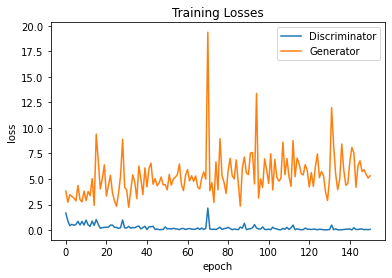

In [25]:
# plot loss
plt.plot(d_losses, '-')
plt.plot(g_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Training Losses')

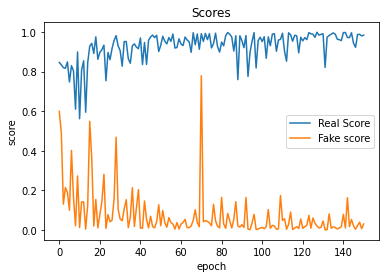

In [26]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real Score', 'Fake score'])
plt.title('Scores');

In [28]:
png_dir = 'MNIST_cDCGAN_results/'
images = []
for file_name in os.listdir(png_dir):
    if file_name.endswith('.png'):
        file_path = os.path.join(png_dir, file_name)
        images.append(imageio.imread(file_path))
imageio.mimsave('demo.gif', images,fps=5)